# Add synthetic gaussian noise to received signal to verify if we are able to perform in the presence of increasing noise/challenging conditions.

### $y = v + w$, where y is received IQ, v is the transmit signal affected by HW and channel artifacts, w is AWGN. 

### We add synthetic noise on top of the received signal as follows:
### $y_s = y + w_s$, for SNR ranging from 0 to 100, in steps of 5. 

### $SNR = 10log_{10}\left( \frac{||y||^2} {||w_s||^2}\right)$, where $||y||^2$ is the average IQ power that we compute empirically from IQ collect as $ \frac{\sum_{i=0}^{N-1} (y_I^2 [i] + y_Q ^2[i])}{N}$, where $y[i] = y_I[i] + jy_Q[i]$, $i$ is the sample index.
### $||w_s||^2 \sim  CN(0, \frac{||y||^2}{10^{\frac{SNR}{10}}})$, where CN is the Complex Gaussian distribution.
### Thus each of $w_I$, $w_Q$ from $w = w_I + w_Q$ is sampled as  $N(0, \frac{1}{2}\frac{||y||^2}{10^{\frac{SNR}{10}}})$

Expected SNR is:  0  and computed SNR is:  0.0009569036345453498
Expected SNR is:  -10  and computed SNR is:  -10.000101312915334
Expected SNR is:  -12  and computed SNR is:  -12.00214228723132
Expected SNR is:  -15  and computed SNR is:  -15.00022013134795
Expected SNR is:  -18  and computed SNR is:  -18.00215971908206
[Errno 17] File exists: '/Users/venkat/Documents/scisrs/Emanations/Phase1/Emanations_JournalCode/Emanations/StandaloneRunningCode//Overlap_Plots_GaussianNoise/'


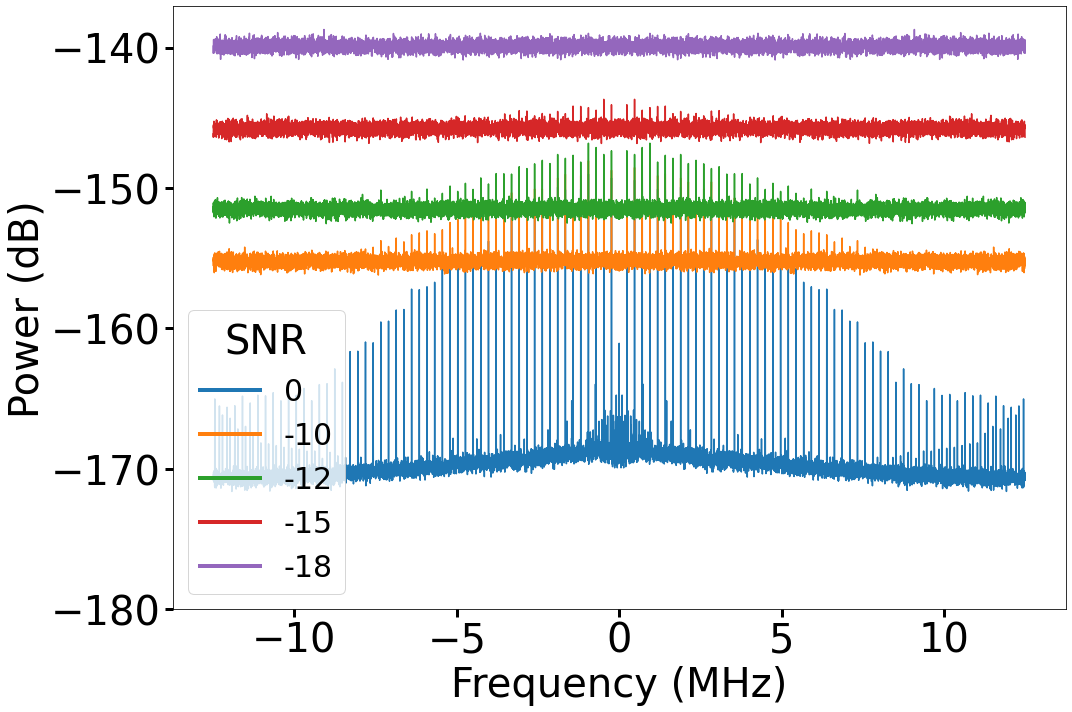

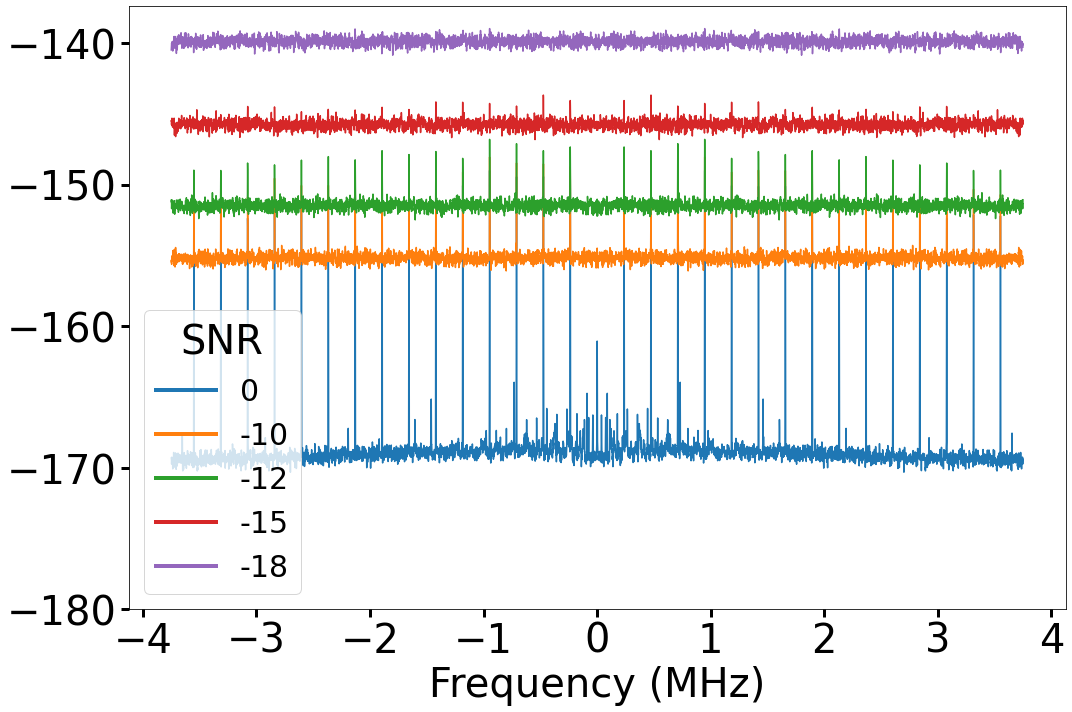

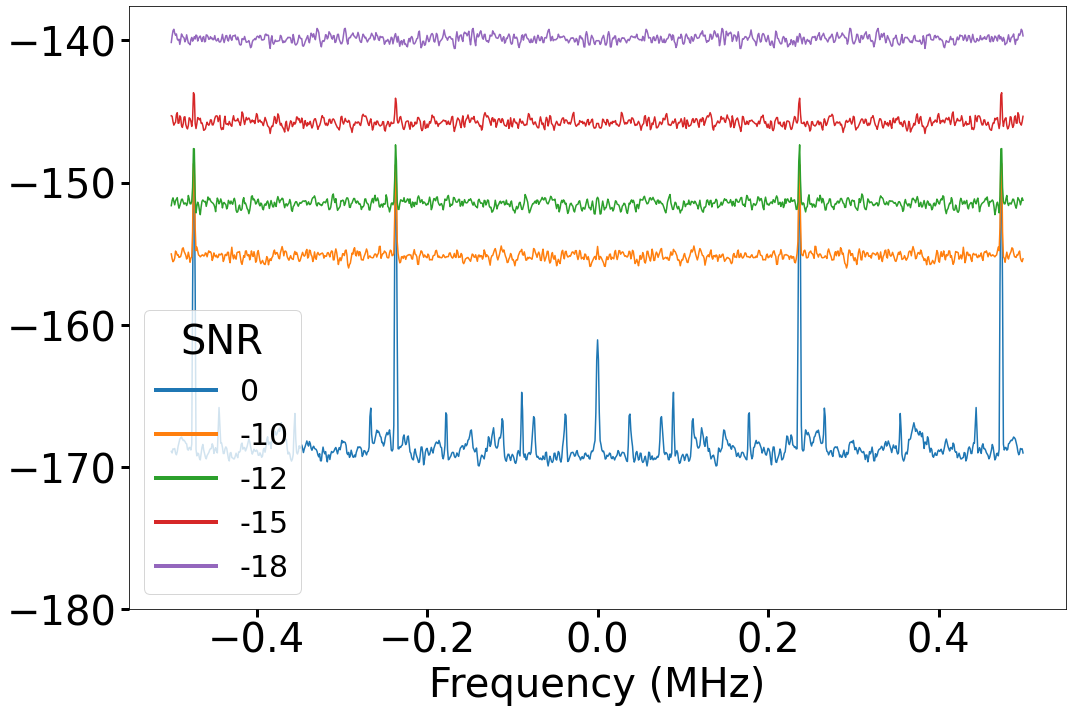

In [3]:
import yaml
import sys
import os
import pickle
import numpy as np
from pytictoc import TicToc
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.signal.windows import kaiser
pythonfiles_location = '/Users/venkat/Documents/scisrs/Emanations/Phase1/Emanations_JournalCode/Emanations/ParamSearch/'
sys.path.insert(1, pythonfiles_location)

pythonfiles_location = os.getcwd() + '/' #'/Users/venkat/Documents/scisrs/Emanations/Phase1/Emanations_JournalCode/Emanations/ParamSearch/'
results_folder_top = os.getcwd() + '/'#'/Users/venkat/Documents/scisrs/Emanations/Phase1/Emanations_JournalCode/Results/Aug24th/final_1/'
IQ_folder = '/Users/venkat/Documents/scisrs/Emanations/IQSamples/June16thCollect/LaptopConnectedToMonitorviaAdaptor/Laptop_MonitorViaAdaptor_25MHzSlice/'

from EmanationDetection_search import *


fs = 25e6
dur_ensemble = 0.001
perc_overlap = 75
kaiser_beta = 10
high_ff_search = True
f_step = 25000000.0

samprate = 200e6
BW = 200  # Mhz
results_dict = {}
numtaps1 = 1000
f_step1 = 25e6
samprate_slice = f_step1
kaiser_beta1 = 20
trial_num = 0
scenario_IQfolder_dict = {}
scenario_IQfolder_dict['Laptop_MonitorViaAdaptor'] = {}
scenario_IQfolder_dict['Laptop_MonitorViaAdaptor']['durationcapture_ms'] = '300'
scenario_list = ['Laptop_MonitorViaAdaptor']
file_path="synapse_emanation_search.yaml"
with open(file_path, 'r') as file:
    config_dict = yaml.safe_load(file)


# Split 200 Mhz capture into 8 logical slot indices: 0 to 7.
# for CF = 200, capture range is 100 to 300 MHz.
# if you want to detect emanation on 150 to 175 MHz, we give slot as 2.
CF_range_start = 200 # in MHz
freq_slot_start = 1
CF_range_end = 300 # in MHz
freq_slot_end = 2
compute_PSD_noAvg = False # We compute PSD without calling Welch to do averaging when set to True.

freq_slot_range = np.arange(freq_slot_start, freq_slot_end, 1)
CF_range = np.arange(CF_range_start, CF_range_end, 200)

CF_slice_range = []
scenario = scenario_list[0]

# duration_capture = scenario_IQfolder_dict[scenario]['durationcapture_ms']

# results_folder = results_folder + '/SNR_' + str(int(SNR)) + '/'
# try:
#     os.mkdir(results_folder)
# except OSError as error:
#     print(error)

CF = CF_range[0]
freq_slot = freq_slot_range[0]
SF_freqslot, EF_freqslot = -samprate / 2 + (freq_slot) * f_step1, -samprate / 2 + (
        freq_slot + 1) * f_step1
CF_freqslot = (SF_freqslot + EF_freqslot) / 2
# shift_freq = -1 * (SF_freqslot + EF_freqslot) / 2
# cutoff1 = f_step1 / 2

filename = 'Scenario_' + scenario + '_CF_' + str(int(CF + CF_freqslot / 1e6)) + 'MHz' + '.pkl'
with open(IQ_folder + filename, 'rb') as dict_file:
    dict_IQ = pickle.load(dict_file)
iq = dict_IQ['IQ']
iq_dict = {}
for SNR in [0,-10, -12, -15, -18]:
    # Generating complex noise for specified SNR
    var_y = np.var(iq)  # np.average(np.abs(iq))
    var_s = 0.5 * (var_y / (np.power(10, (SNR / 10))))
    w_s_I = np.random.normal(loc=0, scale=np.sqrt(var_s), size=len(iq))
    w_s_Q = np.random.normal(loc=0, scale=np.sqrt(var_s), size=len(iq))
    w_s = w_s_I + 1j * w_s_Q
    compute_SNR = 10 * np.log10(var_y / np.var(w_s))  # 10*np.log10(var_y/np.average(np.abs(w_s)))
    print("Expected SNR is: ", SNR, " and computed SNR is: ", compute_SNR)
    iq_s = iq + w_s
    iq_dict[SNR] = iq_s

win_len = np.floor(dur_ensemble * f_step).astype(int)

if high_ff_search:
	kaiser_beta = 10
	f_range = np.arange(-f_step / 2, f_step / 2, f_step / win_len)
else:
	kaiser_beta = 3
	f_range_hh = np.arange(-f_step / 2, f_step / 2, f_step / win_len)
# zoom_perc_list = [30]#[4, 30, 100]

option_processing = 'withPreprocessing'




setaxislim_flag = False # Set this flag to true so taht we manually specify the y limits.

# win_len = np.floor(dur_ensemble * fs).astype(int)
# f_range_iq_plotval = np.arange(-f_step / 2, f_step / 2, fs / len(psd_val_dB))

hyper_param_string = 'Overlap_Plots_GaussianNoise'#'s1_' + str(hyper_param['s1']) + 's2_' + str(hyper_param['s2'])
                         #+ 'p_' + str(hyper_param['p1']) + "_Errthresh_2"

results_folder = results_folder_top + '/' + hyper_param_string + '/'
try:
    os.mkdir(results_folder)
except OSError as error:
    print(error)

for zoom_perc in [100, 30, 4]:

    # for zoom_perc in zoom_perc_list:
    x_lim_max = (zoom_perc/100)*np.max(f_range)
    x_lim_min = -x_lim_max
    max_idx = np.argmin(np.abs(f_range - x_lim_max))
    min_idx = np.argmin(np.abs(f_range - x_lim_min))
    if max_idx >len(f_range):
        max_idx = len(f_range) - 1
    if min_idx < 0:
        min_idx = 0


    SNR_str = "SNR"
    for SNR in list(iq_dict.keys()):
        SNR_str = SNR_str + '_' + str(SNR)
        iq = iq_dict[SNR]
        iq_feature = np.real(np.multiply(iq, np.conj(iq))) # feature extraction
        iq_feature = iq_feature - np.mean(iq_feature) # remove DC

        if compute_PSD_noAvg:
            w = kaiser(len(iq_feature), kaiser_beta)
            w /= np.sum(w)
            w_energy = (np.real(np.vdot(w, w))) / len(w)
            iq_w = np.multiply(iq_feature, w)
            fft_iq = np.fft.fftshift(np.abs(np.fft.fft(iq_w)))
            # fft_iq_slice = np.fft.fftshift(np.abs(np.fft.fft(iq_feature)))
            psd_val = np.multiply(fft_iq, fft_iq) / (w_energy * len(w))
        else:
        # fft_power_dB = 10 * np.log10(fft_power)
            psd_val = WelchPSDEstimate(iq_feature, fs, dur_ensemble, perc_overlap, kaiser_beta, config_dict)
        psd_val_dB = 10 * np.log10(psd_val)
        f_range_zoom = f_range[min_idx:max_idx]#np.linspace(x_lim_min, x_lim_max, num=len(psd_val))
        psd_val_dB_zoom = psd_val_dB[min_idx:max_idx]
        if high_ff_search:
            f_range_updated = np.divide(f_range_zoom,1e6)
            x_label = 'Frequency (MHz)'

        else:
            f_range_updated = np.divide(f_range_zoom, 1e3)
            x_label = 'Frequency (kHz)'

        plt.plot(f_range_updated, psd_val_dB_zoom)
    leg = plt.legend(list(iq_dict.keys()), title="SNR", fontsize=30, title_fontsize= 40)
     # plt.legend()
    # get the individual lines inside legend and set line width
    for line in leg.get_lines():
        line.set_linewidth(4)
        # plt.title("Power/ spectral density", fontsize=40)
        # plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True,length=8,width=3, direction='out')
        # plt.legend(legend_text,fontsize=36)
    # if  option_processing in ['_withPreprocessing', 'withPreprocessing']:
    plt.xlabel(x_label, fontsize=40)
    # if zoom_perc == 100:
    # plt.yticks([])
    if zoom_perc == 100:
        plt.ylabel("Power (dB)", fontsize=40)

    plt.yticks(np.arange(-180, -135, 10), fontsize=40)
    plt.xticks(fontsize=40)


    # ticks = matplotlib.ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(int(CF_snapshot / 1e6) + y / 1e6))
    # ax.yaxis.set_major_formatter(ticks)
    #
    # ticks = matplotlib.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 1e3))
    # ax.xaxis.set_major_formatter(ticks)
    if setaxislim_flag:
        if high_ff_search:
            if option_processing in ['_withPreprocessing', 'withPreprocessing']:
                # plt.ylim([-140,-180])
                plt.yticks(np.arange(-180, -135, 10), fontsize=40)
            else:
                # plt.ylim([-130, -190])
                plt.yticks(np.arange(-190, -105, 20), fontsize=40)
        else:
            if option_processing in ['_withPreprocessing', 'withPreprocessing']:
                # plt.ylim([-150,-230])
                plt.yticks(np.arange(-230,-145,20), fontsize=40)
            else:
                # plt.ylim([-70, -170])
                plt.yticks(np.arange(-170, -70, 20), fontsize=40)

    plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True,
                    length=8, width=3, direction='out')

    # fig.tight_layout()
    plt.gcf().set_size_inches(15, 10)
    plt.subplots_adjust(left=0.12,
                        bottom=0.1,
                        right=0.9,
                        top=0.95,
                        wspace=0.25,
                        hspace=0.25)
    # plt.savefig(save_plot_location + 'EmanationsFromDesktop_CineBench_FFTIQ_IQpower.png', format='png',
    #             bbox_inches='tight', pad_inches=.01)
    plt.tight_layout()

#     plt.savefig(results_folder + SNR_str + '_zp_' + str(zoom_perc) + '.pdf', format='pdf', bbox_inches='tight', pad_inches=.01)
    # plt.savefig(resultssavelocation + 'PSD_' + save_filename + '_zoomperc_' + str(zoom_perc)+ '.pdf', \
    #             format='pdf', bbox_inches='tight', pad_inches=.01)
    # plt.show()
#     plt.close()
    plt.show()
    #plot_PSD(config_dict, iq_feature, fs, dur_ensemble, perc_overlap, kaiser_beta, \
      #   f_range, emanationInputObj.folder, \
       #  PSD_filename_addendum+ option_processing, high_ff_search, zoom_perc_list, option_processing)



## -12 dB, we are able to estimate the fundamental frequency.

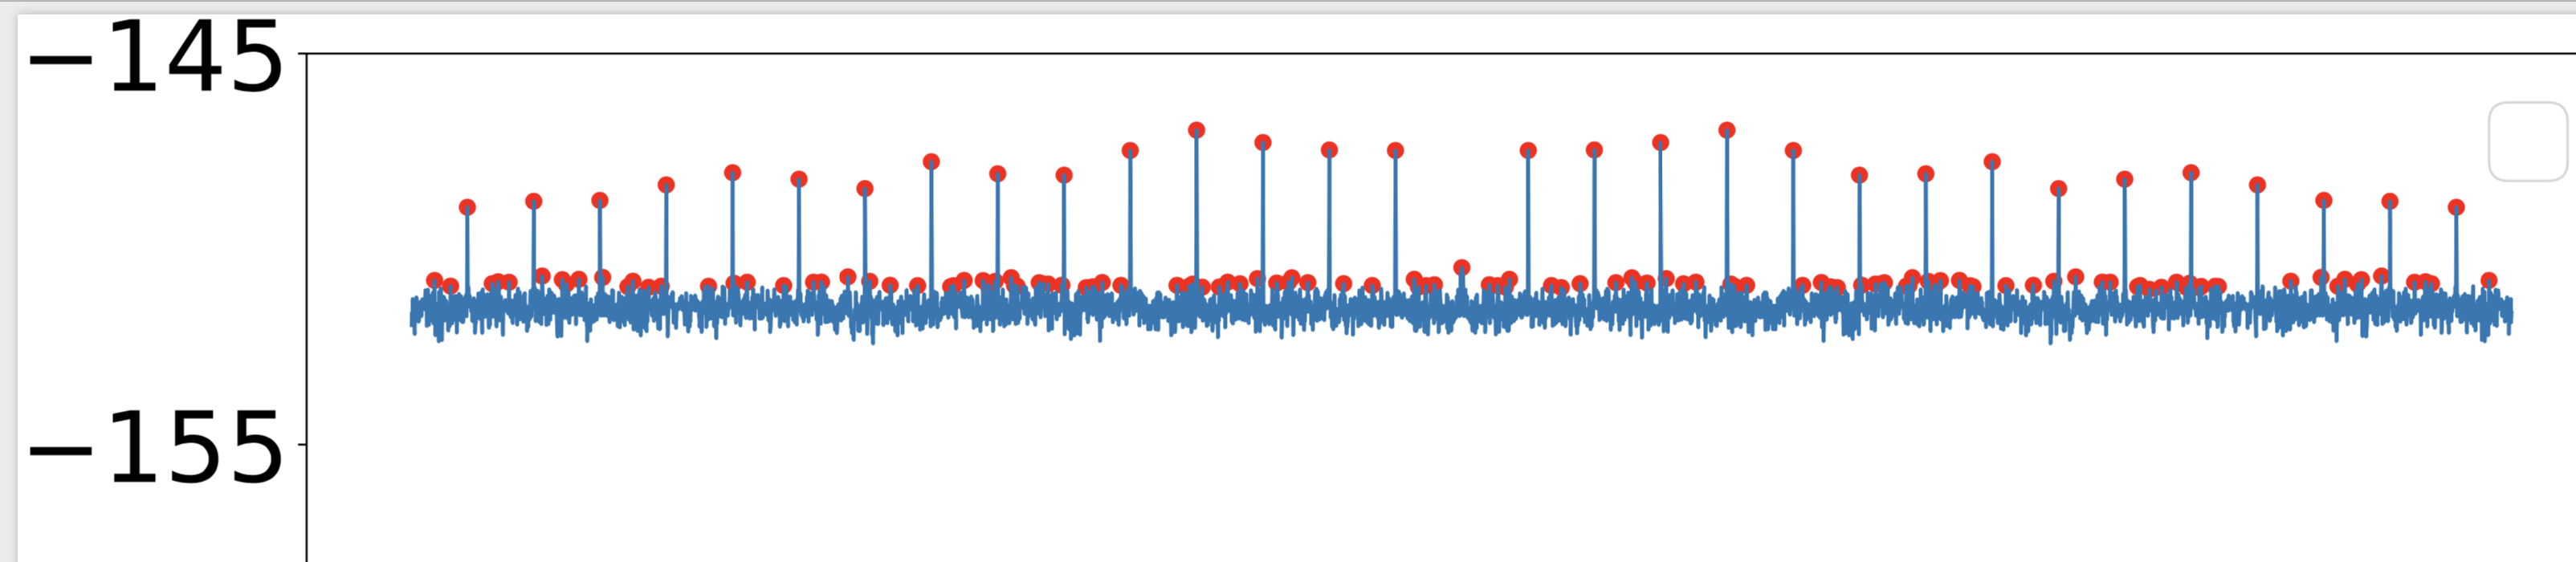

## -14 dB,  we are able to estimate the fundamental frequency.

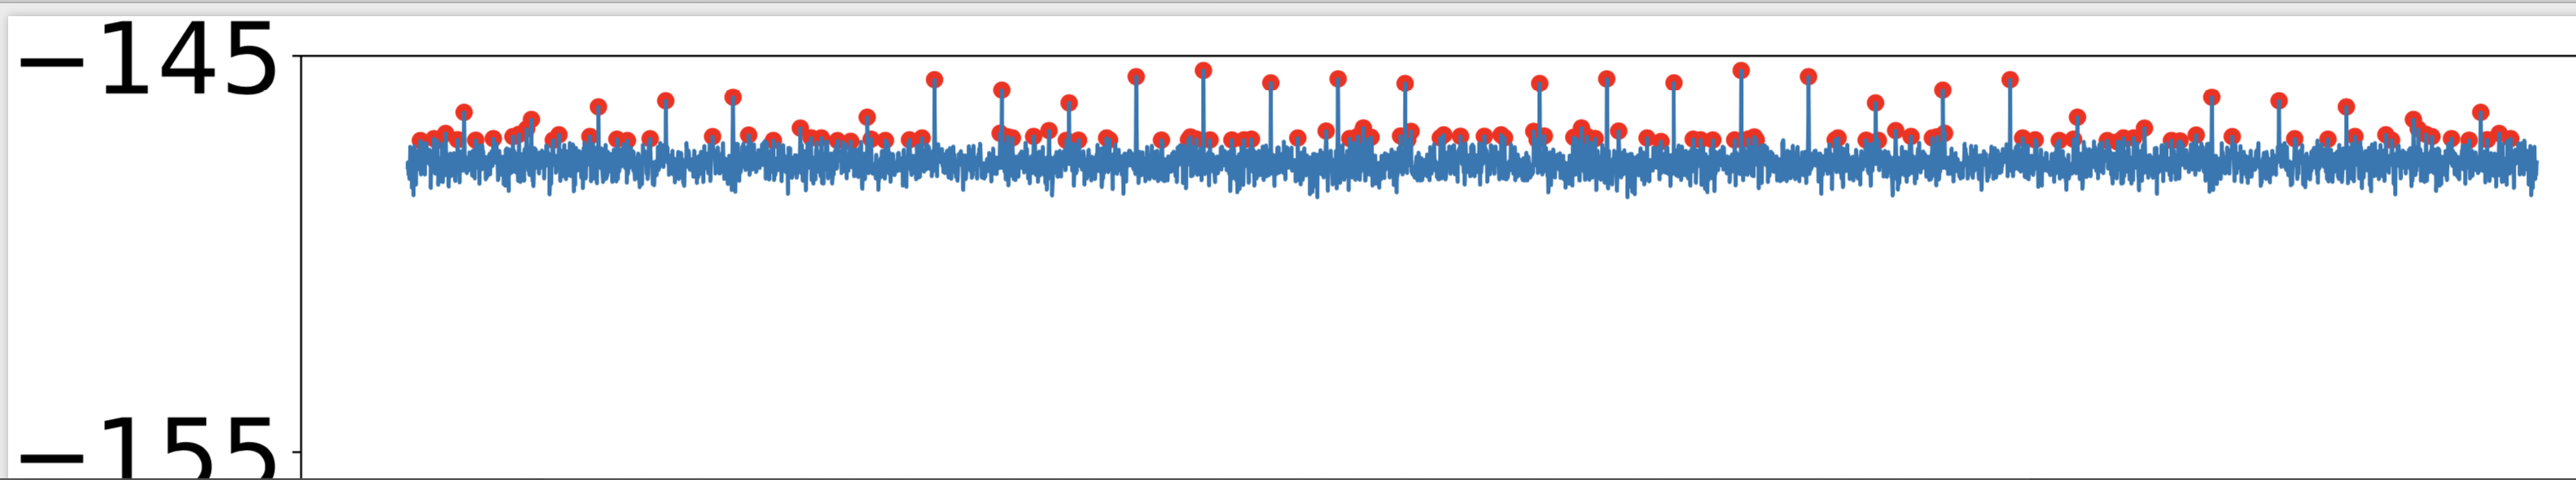

## -16 dB, peaks are too weak and we are unable to estimate the fundamental frequency.


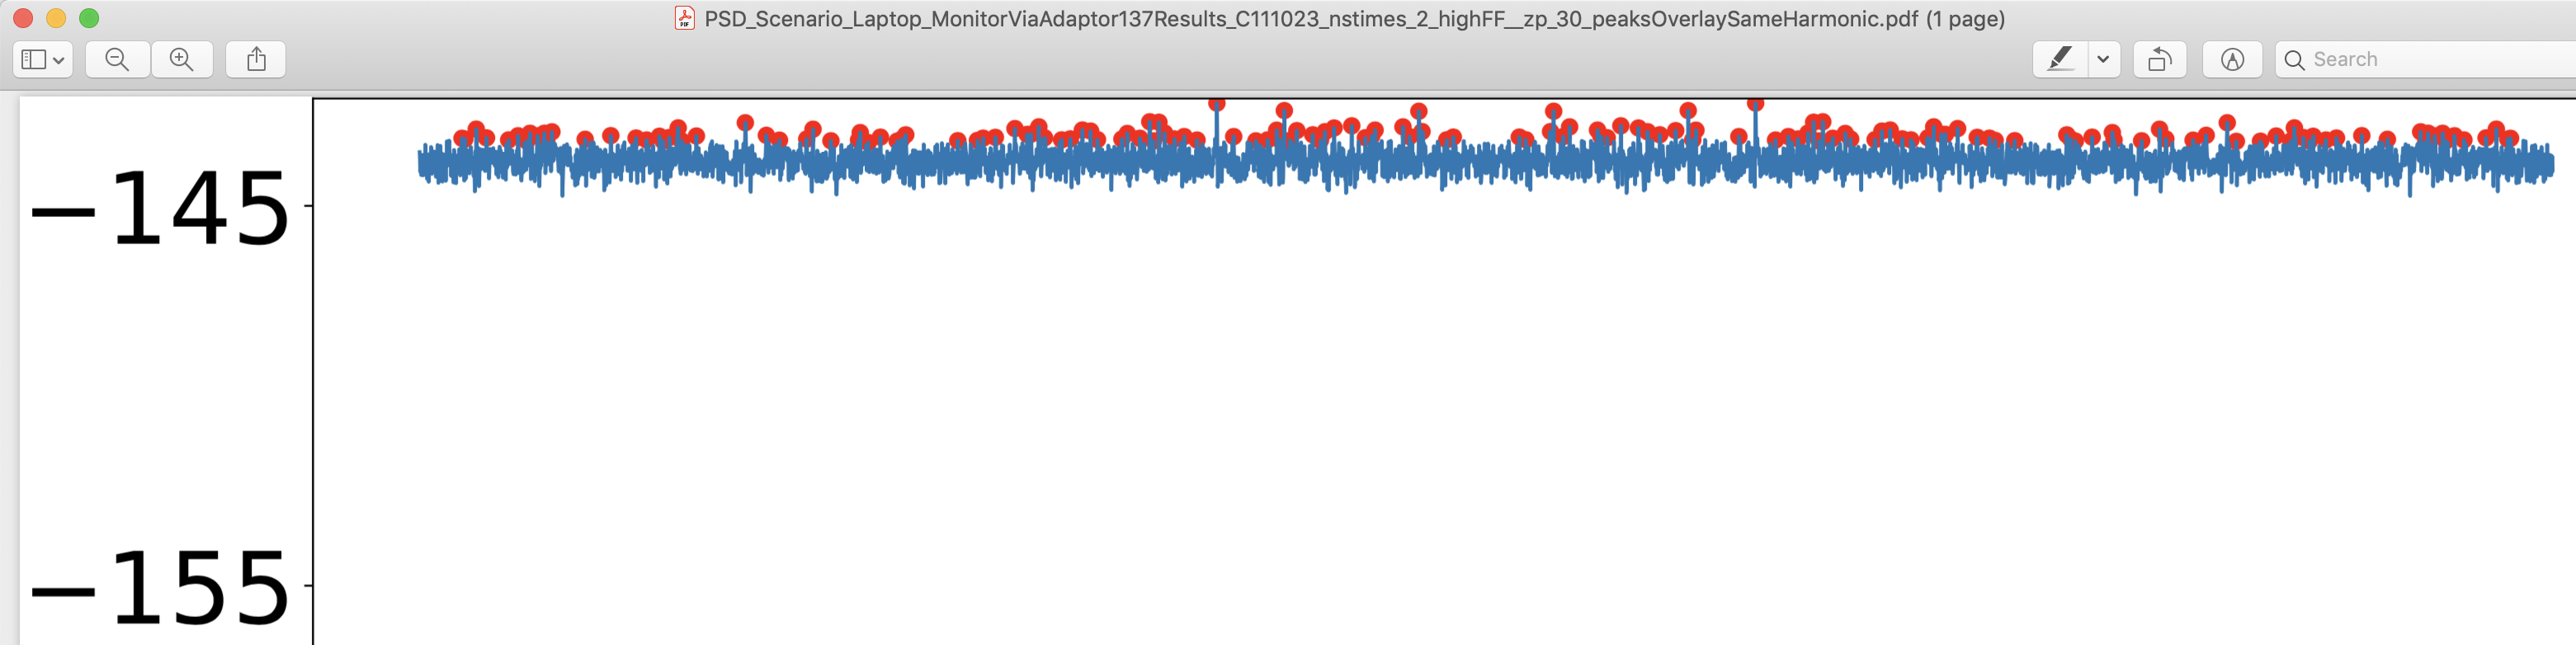